### Final Team 7 Project - Tyre Image Defect Classification using Convolutional Neural Network
### MobileNet Convolution Neural Network Model to Classify Good and Defective Tire Images
### Greg Moore
### University of San Diego
### AAI-521: Applied Computer Vision for AI
### Professor Roozbeh Sadeghian, PhD.
### 12/9/2024

### MobileNet CNN Model to Classify Good/Defective Tire Images
The following code and workflow builds, trains, and evaluates a binary classifier using the MobileNet model base with custom layers for classifying images of tires as Good or Defective. The binary image classification pipeline using the MobileNet architecture involves categorizing tire images into two classes: Good or Defective The workflow is as follows:

Prepare a dataset of tire images for binary classification (Good vs. Defective)
Use a pre-trained MobileNet as the feature extractor
Add custom layers for classification
Train and evaluate the model
Provide metrics and visualizations

### Split Dataset into Training (70%), Validation (20%), Testing (10%) (If Necessary)
If Necessary: The downloaded Tyre Image Dataset is found in two seperate folders, Good and Defective. This code splits these two folders into 3 subfolders as listed above each containing a Good and Defective subfolder of tire images. After downloading the dataset from the link below, adjust the path to the dataset and run code in next cell to set up data for MobileNet model training and classification; only need to do this first time.

Link to Dataset: TyreNet: A High-quality Annotated Dataset for Tyre Defect Classification with Deep Learning Models
https://doi.org/10.17632/32b5vfj6tc.1


In [ ]:
# pip install split-folders

import splitfolders

# Path to the dataset folder containing 'Good' and 'Defective' subfolders
input_folder = "C:/Greg/MSAI/AAI_521/FINAL/tyre_dataset/Dataset"

# Output folder for the split datasets
output_folder = "C:/Greg/MSAI/AAI_521/FINAL/tyre_dataset/split"

# Split the dataset into training (70%), validation (20%), and testing (10%)
splitfolders.ratio(
    input_folder, 
    output=output_folder, 
    seed=42, 
    ratio=(0.7, 0.2, 0.1), 
    group_prefix=None
)

### Load Libraries

In [1]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import numpy as np
import os
from PIL import Image
import seaborn as sns

### Paths to Training, Validation, Testing Folders

In [2]:
# Paths to the split dataset folders with two subfolders under each one, Good and Defective
train_dir = "C:/Greg/MSAI/AAI_521/FINAL/tyre_dataset/split/train"
val_dir = "C:/Greg/MSAI/AAI_521/FINAL/tyre_dataset/split/val"
test_dir = "C:/Greg/MSAI/AAI_521/FINAL/tyre_dataset/split/test"

### Display 3 Good Tire Images and 3 Defective Tire Images from Dataset

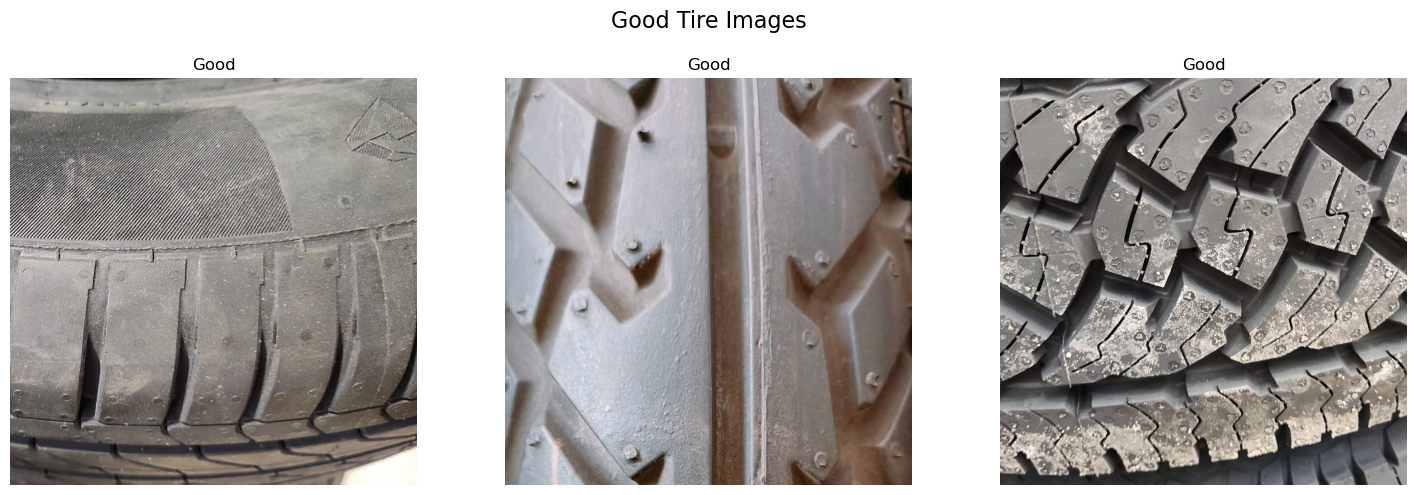

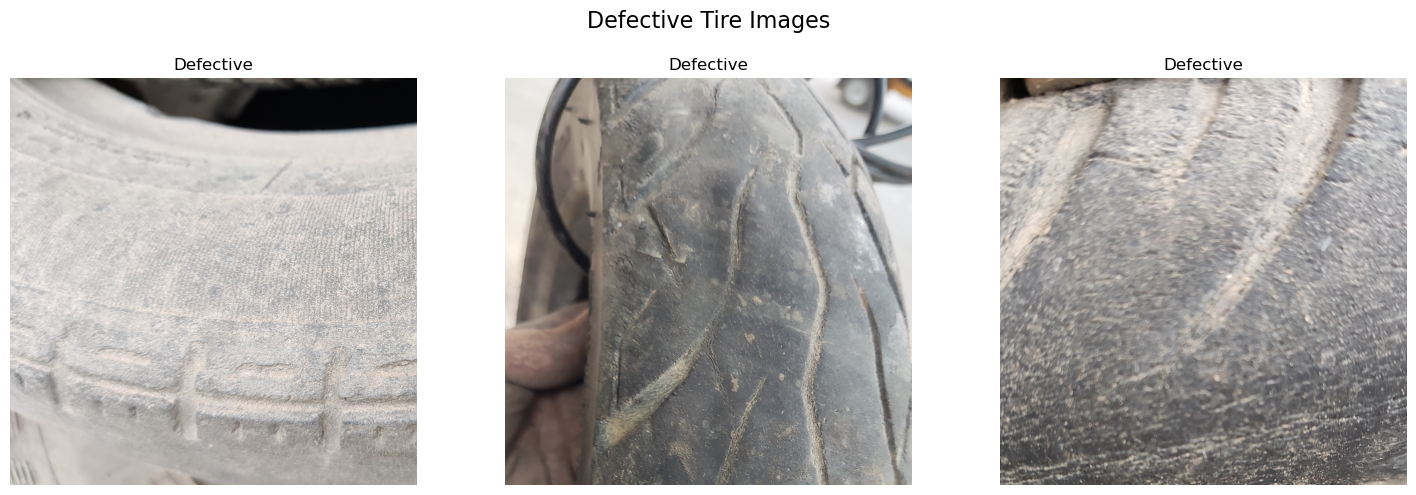

In [3]:
# Display 3 images for Good and Defective tires
num_images = 3

# Define paths to subfolders Good and Defective
# Identify 'Good' and 'Defective' tire images by subfolder
good_dir = os.path.join(train_dir, "Good")
defective_dir = os.path.join(train_dir, "Defective")

# Get image file names
good_images = [os.path.join(good_dir, img) for img in os.listdir(good_dir) if img.endswith(('.png', '.jpg', '.jpeg'))]
defective_images = [os.path.join(defective_dir, img) for img in os.listdir(defective_dir) if img.endswith(('.png', '.jpg', '.jpeg'))]

# Limit to number of images
good_images = good_images[:num_images]
defective_images = defective_images[:num_images]

# Plotting for "Good" images
fig, axes = plt.subplots(1, num_images, figsize=(15, 5))
fig.suptitle('Good Tire Images', fontsize=16)

# Display 3 images from the "Good" folder
for i, img_path in enumerate(good_images):
    img = Image.open(img_path)
    axes[i].imshow(img)
    axes[i].set_title("Good")
    axes[i].axis('off')

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

# Plotting for "Defective" images
fig, axes = plt.subplots(1, num_images, figsize=(15, 5))
fig.suptitle('Defective Tire Images', fontsize=16)

# Display 3 images from the "Defective" folder
for i, img_path in enumerate(defective_images):
    img = Image.open(img_path)
    axes[i].imshow(img)
    axes[i].set_title("Defective")
    axes[i].axis('off')

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

### Setup Image Parameters for Size, Batch, Epochs, Learning Rate

In [21]:
# Set up image parameters
# Define input image dimensions (224x224 pixels) to resize input images
image_size = (224, 224)
# Define batch size for number of images processed together in
# one forward/backward pass during training.
batch_size = 32
# Define number of complete passes through the entire training dataset
epochs = 20
# Step size for optimizer to adjust model weights during training
learning_rate = 0.001

### Data Generators and Augmentation: Normalize, Rotations, Flips

In [22]:
# Data augmentation
# Image data generators
# Normalize pixel values to [0,1]
# Apply random rotations and flips to training data
# Randomly rotate images by up to 30 degrees for augmentation
# Randomly flip images horizontally
train_datagen = ImageDataGenerator(rescale=1.0/255.0, rotation_range=30, horizontal_flip=True)
# Only rescale pixel values without augmentation for validation
# and testing (no randomness)
val_datagen = ImageDataGenerator(rescale=1.0/255.0)
test_datagen = ImageDataGenerator(rescale=1.0/255.0)

### Load Datasets and Prepare for Training, Validation, Testing

In [23]:
# Load datasets from directories and prepare batches for
# training, validation, and testing. Resize image to 224x224
# pixels, generate batches of 32 images, binary classification
# (Good/Defective).
train_generator = train_datagen.flow_from_directory(
    train_dir, target_size=image_size, batch_size=batch_size, class_mode="binary"
)
val_generator = val_datagen.flow_from_directory(
    val_dir, target_size=image_size, batch_size=batch_size, class_mode="binary"
)
# For test generator keep images in order for evaluation
test_generator = test_datagen.flow_from_directory(
    test_dir, target_size=image_size, batch_size=batch_size, class_mode="binary", shuffle=False
)

Found 1188 images belonging to 2 classes.
Found 339 images belonging to 2 classes.
Found 171 images belonging to 2 classes.


### Load Pre-trained MobileNet Model with no Top Classifier Layer

In [24]:
# Load a pre-trained MobileNet model without the top classifier layer
# Load pre-trained on ImageNet, exclude the default fully connected
# layers for ImageNet classes, set input size to 224x224 with
# 3 color channels (RGB)
base_model = MobileNet(weights="imagenet", include_top=False, input_shape=(224, 224, 3))

### Freeze MobileNet Base Model from Updates

In [25]:
# Prevent updates to the pre-trained layers during training
# Freezes the pre-trained MobileNet weights to prevent them from
# updating during training. Only the custom layers will learn.
base_model.trainable = False

### Add Custom Layers for Binary Classification

In [26]:
# Add custom layers for binary classification
# Take the output of the frozen MobileNet base
x = base_model.output
# Reduce spatial dimensioins to a single vector for each feature channel
x = GlobalAveragePooling2D()(x)
# Add fully connected layers with ReLU and Dropout for regularization
# Add a fully connected layer with 128 neurons and ReLU activation
x = Dense(128, activation="relu")(x)
# Apply dropout with 50% probability to reduce overfitting
x = Dropout(0.5)(x)
# Output layer: Single neuron with sigmoid activation for binary output
predictions = Dense(1, activation="sigmoid")(x)

### Combine MobileNet Base and Custom Head to One Model

In [27]:
# Create the final model
# Combine the MobileNet base and custom head into a single model
model = Model(inputs=base_model.input, outputs=predictions)

### Compile the Model

In [28]:
# Compile the model
# Use the Adam optimizer with the specified learning rate (.001),
# loss function for binary classification, track accuracy during
# training and evaluation
model.compile(optimizer=Adam(learning_rate=learning_rate), loss="binary_crossentropy", metrics=["accuracy"])

### Train the Model and Generate Loss/Accuracy for Analysis

In [29]:
# Train the model using the prepared data generators
# Store training and validation loss/accuracy for analysis
# Validate model performance on validation data after each epoch
history = model.fit(
    train_generator,
    epochs=epochs,
    validation_data=val_generator
)

C:\Users\gregm\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
38/38 ━━━━━━━━━━━━━━━━━━━━ 102s 3s/step - accuracy: 0.7469 - loss: 0.5720 - val_accuracy: 0.9115 - val_loss: 0.2204
Epoch 2/20
38/38 ━━━━━━━━━━━━━━━━━━━━ 96s 3s/step - accuracy: 0.8998 - loss: 0.2279 - val_accuracy: 0.9086 - val_loss: 0.2471
Epoch 3/20
38/38 ━━━━━━━━━━━━━━━━━━━━ 98s 3s/step - accuracy: 0.9067 - loss: 0.2452 - val_accuracy: 0.9322 - val_loss: 0.1852
Epoch 4/20
38/38 ━━━━━━━━━━━━━━━━━━━━ 95s 3s/step - accuracy: 0.9330 - loss: 0.1600 - val_accuracy: 0.9322 - val_loss: 0.1833
Epoch 5/20
38/38 ━━━━━━━━━━━━━━━━━━━━ 95s 3s/step - accuracy: 0.9486 - loss: 0.1440 - val_accuracy: 0.9351 - val_loss: 0.1694
Epoch 6/20
38/38 ━━━━━━━━━━━━━━━━━━━━ 95s 3s/step - accuracy: 0.9563 - loss: 0.1146 - val_accuracy: 0.9381 - val_loss: 0.1582
Epoch 7/20
38/38 ━━━━━━━━━━━━━━━━━━━━ 95s 3s/step - accuracy: 0.9553 - loss: 0.1184 - val_accuracy: 0.9381 - val_loss: 0.1635
Epoch 8/20
38/38 ━━━━━━━━━━━━━━━━━━━━ 97s 3s/step - accuracy: 0.9562 - loss: 0.1037 - val_accuracy: 0.9381 - val_loss

### Evaluate the Model for Loss/Accuracy

In [30]:
# Evaluate the model
test_loss, test_accuracy = model.evaluate(test_generator)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

6/6 ━━━━━━━━━━━━━━━━━━━━ 10s 2s/step - accuracy: 0.9652 - loss: 0.0797
Test Loss: 0.07286007702350616
Test Accuracy: 0.9707602262496948


### Generate Predictions, Classify, and Display Classification Report

In [31]:
# Predictions and metrics
# Generate predictions and classify them as binary labels
test_generator.reset()
predictions = model.predict(test_generator)
predicted_classes = (predictions > 0.5).astype(int).flatten()
true_classes = test_generator.classes
class_labels = list(test_generator.class_indices.keys())

# Classification report
report = classification_report(true_classes, predicted_classes, target_names=class_labels)
print("Classification Report:\n", report)

6/6 ━━━━━━━━━━━━━━━━━━━━ 10s 2s/step
Classification Report:
               precision    recall  f1-score   support

   Defective       1.00      0.94      0.97        87
        Good       0.94      1.00      0.97        84

    accuracy                           0.97       171
   macro avg       0.97      0.97      0.97       171
weighted avg       0.97      0.97      0.97       171



### Print Confustion Matrix

In [32]:
# Confusion matrix
conf_matrix = confusion_matrix(true_classes, predicted_classes)
print("Confusion Matrix:\n", conf_matrix)

Confusion Matrix:
 [[82  5]
 [ 0 84]]


### Plot Confusion Matrix

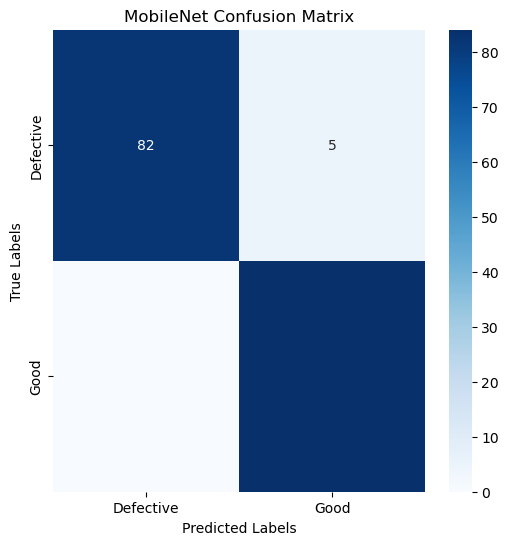

In [33]:
# Plot Confusion Matrix
plt.figure(figsize=(6, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.title('MobileNet Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

### Plot Training History Accuracy and Loss over Epochs

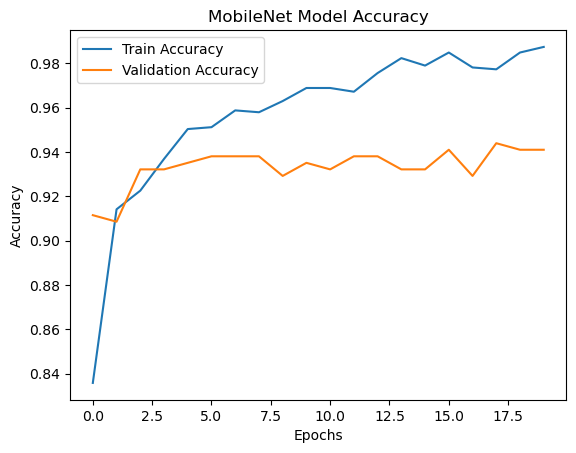

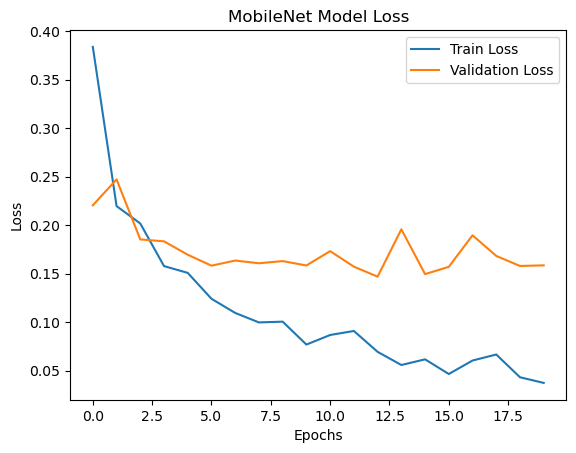

In [34]:
# Plot training history
#plt.figure(figsize=(12, 4))
#plt.figure(figsize=(6, 4))

# Accuracy plot
#plt.subplot(1, 2, 1)
plt.plot(history.history["accuracy"], label="Train Accuracy")
plt.plot(history.history["val_accuracy"], label="Validation Accuracy")
plt.title("MobileNet Model Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

# Loss plot
#plt.subplot(1, 2, 2)
plt.plot(history.history["loss"], label="Train Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.title("MobileNet Model Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()